In [97]:
import numpy as np

In [98]:

data = np.load("./HW02/data/data.npz")
Xtr = data["Xtr"] #Train inputs
Ytr = data["Ytr"] #Train labels
Xte = data["Xte"] #Test inputs
Yte = data["Yte"] #Test labels

In [99]:
def krbf(x1,x2,beta=0.1):
    return np.exp(-beta*np.linalg.norm(x1-x2)**2)

In [100]:
theta=[1,1,1]
x1=Xtr[0]
x2=Xtr[1]
print(f'X1:{x1}, X2:{x2}')

X1:[-1.04891018 -1.36930639  0.8309701   0.39146673 -0.28062196 -0.39550548
  0.9952759   0.12794098  1.39897922 -0.72993351  0.64032121 -0.6940647
 -0.90592121], X2:[-1.04891018 -1.36930639 -1.3326879  -0.07224493 -0.31790614 -0.39550548
  0.9952759   1.18362036 -0.7148069  -0.39858211  0.64032121 -0.6940647
 -0.90592121]


In [101]:
print(f'rbf(x1,x1){krbf(x1,x1)}, rbf(x2,x2):{krbf(x2,x2)}, rbf(x1,x2):{krbf(x2,x1)}')

rbf(x1,x1)1.0, rbf(x2,x2):1.0, rbf(x1,x2):0.34679623141839294


In [102]:
def gtheta(params,x,data):
    return params[-1]+np.sum([params[i]*krbf(data[i],x) for i in range(len(data))])

In [106]:
print(np.sign(gtheta(theta,x1,Xdata)))

1.0


In [300]:
def risk(params,xdata,ydata,lambdas=0.1):
    n=len(xdata)
    r1=np.sum(np.log(1+np.exp(-ydata[i]*gtheta(params,xdata[i],xdata))) for i in range(n))
    r2=np.sum([params[i]*params[j]*krbf(xdata[i],xdata[j]) for i in range(n) for j in range(n)])*lambdas/2
    return (r1+r2)/n

In [409]:
from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

In [144]:
theta=[1,1,1]
Xdata=Xtr[:2]
Ydata=Ytr[:2]
print(f'Risk:{risk(theta,Xdata,Ydata)}')

Risk:[2.50550683]


/var/folders/zm/t5q0r2zn06j6v7256cjw7_j80000gn/T/ipykernel_53284/3988675311.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  r1=np.sum(np.log(1+np.exp(-ydata[i]*gtheta(params,xdata[i],xdata))) for i in range(n))


In [156]:
def risk_gradient(params,xdata,ydata,lambdas=0.1):
    gradient=[]
    n=len(xdata)
    for i in range(n):
        loss_term=[]
        regularized_term=[]
        for j in range(n):
            loss_term.append(1/(np.exp(ydata[i]*gtheta(params,xdata[i],xdata))+1)*-ydata[i]*krbf(xdata[i],xdata[j]))
            regularized_term.append(lambdas*params[j]*krbf(xdata[i],xdata[j]))
        gradient.append((np.sum(loss_term+regularized_term))/n)
    gradient.append((np.sum([1/(np.exp(ydata[i]*gtheta(params,xdata[i],xdata))+1)*-ydata[i]]))/n)
    return gradient

In [301]:
print(f'risk_gradients are :{risk_gradient(theta,Xdata,Ydata)}')

risk_gradients are :[array([0.68193629]), array([0.68193629]), 0.4563396189287508]


/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [372]:
import numpy as np
import scipy.special 
from scipy.optimize import minimize

class klr:

    def __init__(self,Xtr,lam=0.1,beta=0.1):
        self.lam  = lam
        self.beta = beta
        self.Xtr  = Xtr
        self.tol  = 1e-6
        self.method = "L-BFGS-B"
        self.theta_hat = []
        
    def compute_kernel(self,X,Xprime):
        #X.shape[0] is column and Xprime.shape[0] is rows
        krbf=np.array([[np.exp(-self.beta*np.linalg.norm(X[i]-Xprime[j])**2) for i in range(X.shape[0])] for j in range(Xprime.shape[0])])
        return krbf
    
    def discriminant(self,theta,X):
        K=self.compute_kernel(self.Xtr,X)
        return theta[-1]+K@np.array(theta[:-1])

    def risk(self,theta,X,Y):
        self.discriminant=memory.cache(self.discriminant)
        self.compute_kernel=memory.cache(self.compute_kernel)
        Discriminant=self.discriminant(theta,X)
        K=self.compute_kernel(X,X)

        theta=np.array(theta)
        n=len(X)
        r1=np.sum([np.log(1+np.exp(-Y[i]*Discriminant[i])) for i in range(n)])
        r2=np.sum([theta[i]*theta[j]*K[i][j] for i in range(n) for j in range(n)])*self.lam/2
        return (r1+r2)/n

    def risk_grad(self,theta,X,Y,K=0):
        gradient=[]
        n=len(X)
        self.discriminant=memory.cache(self.discriminant)
        self.compute_kernel=memory.cache(self.compute_kernel)
        Discriminant=self.discriminant(theta,X)
        K=self.compute_kernel(X,X)
        grad_b=[]
        for i in range(n):
            inner_gradient=[]
            for j in range(n):
                inner_gradient.append((1/(np.exp(Y[i]*Discriminant[i])+1)*-Y[i]*K[i][j]
                                +self.lam*theta[j]*K[i][j])/n)
            gradient.append(sum(inner_gradient))
            grad_b.append(-Y[i]/(1+np.exp(Y[i]*Discriminant[i])))
        gradient.append((np.sum(grad_b))/n)
        return gradient

    def fit(self,X,Y):
        theta0=np.zeros(len(X)+1)
        minimizing=minimize(self.risk,theta0,args=(X,Y),tol=self.tol,method=self.method,options={"disp":False,"maxfun":1e+10,"maxiter":1000})
        self.theta_hat=minimizing.x
        return minimizing.fun
        
        
    def predict(self,theta,X):
        return np.sign(self.discriminant(theta,X))
    
    def classification_error(self,theta,X,Y):
        ce=0
        Y_pred=self.predict(theta,X)
        for i in range(len(Y)):
            if Y[i]==Y_pred[i]:
                ce+=1
        return (1-ce/len(Y))*100        

In [332]:
model=klr(Xtr[:3])
print(model.risk([1,1,1,1],Xtr[:3],Ytr[:3]))
print(model.risk_grad([1,1,1,1],Xtr[:3],Ytr[:3]))
from scipy import optimize
eps = np.sqrt(np.finfo(np.float).eps)
optimize.approx_fprime([1,1,1,1],model.risk,eps,Xtr[:3],Ytr[:3])

2.9651072534386853
[array([0.57788477]), array([0.66227487]), array([0.65490967]), 0.9432865518582494]


/var/folders/zm/t5q0r2zn06j6v7256cjw7_j80000gn/T/ipykernel_53284/3467251820.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps = np.sqrt(np.finfo(np.float).eps)


array([0.58051652, 0.66068947, 0.65386331, 0.94328654])

## Q7a

In [333]:
print(model.compute_kernel(Xte[:4],Xtr[:3]))

[[0.09357018 0.02918977 0.1500139  0.09995688]
 [0.06968701 0.01661554 0.242886   0.12241315]
 [0.05922661 0.0204159  0.15276502 0.28253882]]


## Q7b

In [335]:
model=klr(Xtr[:3])
print(model.discriminant([1,1,1,-0.5],Xte[:4]))


[-0.27751619 -0.43377879  0.04566492  0.00490885]


## Q7c

In [324]:
model=klr(Xtr[:3])
print(model.predict([1,1,1,-0.5],Xte[:4]))

[-1. -1.  1.  1.]


## Q7d

In [325]:
model=klr(Xtr[:3])
print(model.risk([1,1,1,-0.5],Xtr[:3],Ytr[:3]))

1.6451804988265282


## Q7e

In [326]:
model=klr(Xtr[:3])
print(model.risk_grad([1,1,1,-0.5],Xtr[:3],Ytr[:3]))

[array([0.48213003]), array([0.56994837]), array([0.56219413]), 0.78801513436508]


## Q7f

In [405]:
model=klr(Xtr[:10])
test=model.fit(Xtr[:10],Ytr[:10])


In [406]:

print(model.theta_hat)

[-1.09578631 -0.64489728 -0.7214171  -0.71084364 -1.13701259 -1.06009207
  2.15855564  2.40217648  1.96209868 -1.15250871 -0.97151541]


## Q7g

In [378]:
model=klr(Xtr)
fit=model.fit(Xtr,Ytr)

In [337]:
print(fit)

[-1.51424252e+00 -2.69943874e-01 -1.67580851e-01 -4.69865471e-01
 -1.22209303e+00 -1.17774854e+00  5.04201176e-01  2.04674408e+00
  1.00638737e+00 -1.92882434e+00  7.71049785e-01 -1.02133409e+00
 -8.49251473e-01  6.03609287e-01 -2.37476876e+00 -1.31460863e+00
 -5.19180051e-01  3.79708993e-01  3.02129037e-01  1.14606580e+00
  1.07222963e+00 -4.09820950e-01 -2.09801355e+00 -3.04347325e-01
 -2.02203269e+00 -2.35782031e+00 -7.96988751e-01  1.22211661e+00
  1.99134584e+00  9.71054872e-01 -1.53799695e+00 -1.02019887e+00
 -2.61376768e+00 -5.53520682e-01 -1.03320022e-01  1.35300154e+00
  3.80303744e-01  6.79549671e-01  5.38759598e+00  1.25085732e+00
  1.13941640e+00 -1.50139111e+00 -1.41964484e+00  3.40164176e+00
  2.28459858e+00 -2.34011437e-01 -3.95897710e-01 -3.00615313e+00
 -6.57709736e-01  1.29153411e+00 -1.55652009e+00 -2.24164422e+00
 -1.09384926e-01  9.55919888e-01  5.40786546e+00  5.61181941e-01
 -6.15006744e-01 -1.12169827e+00  2.86249579e+00  1.06649032e+00
  2.25934234e+00 -3.10973

In [379]:
cetr=model.classification_error(model.theta_hat,Xtr,Ytr)
cete=model.classification_error(model.theta_hat,Xte,Yte)

print(f'training Classification Error:{cetr}    Test Classification error:{cete}')

training Classification Error:3.864734299516903    Test Classification error:12.222222222222223


## Q7h


In [365]:
Xvl=Xtr[:52]
Xtr2=Xtr[53:]
Yvl=Ytr[:52]
Ytr2=Ytr[53:]


In [411]:
values = [0.0001,0.001,0.01,0.1,1,10]
low_err=np.inf
best_beta=values[0]
best_lmbda=values[0]
loss_data=[]
val_ce_data=[]
tr_ce_data=[]
for beta in values:
    loss_vals=[]
    val_ce_vals=[]
    tr_ce_vals=[]
    for lmbda in values:
        model=klr(Xtr2,beta,lmbda)
        fit=model.fit(Xtr2,Ytr2)
        vlce=model.classification_error(model.theta_hat,Xvl,Yvl)
        trce=model.classification_error(model.theta_hat,Xtr2,Ytr2)
        loss_vals.append(fit)
        val_ce_vals.append(vlce)
        tr_ce_vals.append(trce)
        print(f"Beta:{beta} Lambda: {lmbda} Validation Classification error: {vlce} Training classification error: {trce}")
        memory.clear()
        if vlce<low_err:
            low_err=vlce
            best_beta=beta
            best_lmbda=lmbda
    loss_data.append(loss_vals)
    val_ce_data.append(val_ce_vals)
    tr_ce_data.append(tr_ce_vals)

print(f'Best Beta is:{best_beta} Best lambda is: {best_lmbda}')

        
    

Beta:0.0001 Lambda: 0.0001 Validation Classification error: 11.538461538461542 Training classification error: 22.077922077922075


Beta:0.0001 Lambda: 0.001 Validation Classification error: 17.307692307692314 Training classification error: 18.181818181818176


Beta:0.0001 Lambda: 0.01 Validation Classification error: 9.615384615384615 Training classification error: 11.688311688311693


Beta:0.0001 Lambda: 0.1 Validation Classification error: 25.0 Training classification error: 0.0


Beta:0.0001 Lambda: 1 Validation Classification error: 32.692307692307686 Training classification error: 0.0


Beta:0.0001 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0


Beta:0.001 Lambda: 0.0001 Validation Classification error: 11.538461538461542 Training classification error: 21.42857142857143


Beta:0.001 Lambda: 0.001 Validation Classification error: 17.307692307692314 Training classification error: 18.181818181818176


Beta:0.001 Lambda: 0.01 Validation Classification error: 11.538461538461542 Training classification error: 14.935064935064934


Beta:0.001 Lambda: 0.1 Validation Classification error: 23.076923076923073 Training classification error: 0.0


Beta:0.001 Lambda: 1 Validation Classification error: 32.692307692307686 Training classification error: 0.0


Beta:0.001 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0


Beta:0.01 Lambda: 0.0001 Validation Classification error: 9.615384615384615 Training classification error: 22.077922077922075


Beta:0.01 Lambda: 0.001 Validation Classification error: 13.461538461538458 Training classification error: 18.181818181818176


Beta:0.01 Lambda: 0.01 Validation Classification error: 17.307692307692314 Training classification error: 18.181818181818176


Beta:0.01 Lambda: 0.1 Validation Classification error: 23.076923076923073 Training classification error: 0.0


Beta:0.01 Lambda: 1 Validation Classification error: 30.76923076923077 Training classification error: 0.0


Beta:0.01 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0


Beta:0.1 Lambda: 0.0001 Validation Classification error: 7.692307692307687 Training classification error: 20.12987012987013


Beta:0.1 Lambda: 0.001 Validation Classification error: 13.461538461538458 Training classification error: 17.532467532467532


Beta:0.1 Lambda: 0.01 Validation Classification error: 15.384615384615385 Training classification error: 16.883116883116877


Beta:0.1 Lambda: 0.1 Validation Classification error: 19.23076923076923 Training classification error: 1.9480519480519431


Beta:0.1 Lambda: 1 Validation Classification error: 23.076923076923073 Training classification error: 0.0


Beta:0.1 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0


Beta:1 Lambda: 0.0001 Validation Classification error: 25.0 Training classification error: 27.922077922077925


Beta:1 Lambda: 0.001 Validation Classification error: 13.461538461538458 Training classification error: 17.532467532467532


Beta:1 Lambda: 0.01 Validation Classification error: 13.461538461538458 Training classification error: 16.883116883116877


Beta:1 Lambda: 0.1 Validation Classification error: 13.461538461538458 Training classification error: 12.337662337662337


Beta:1 Lambda: 1 Validation Classification error: 36.53846153846154 Training classification error: 0.0


Beta:1 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0


Beta:10 Lambda: 0.0001 Validation Classification error: 40.38461538461539 Training classification error: 49.350649350649356


Beta:10 Lambda: 0.001 Validation Classification error: 23.076923076923073 Training classification error: 25.97402597402597


Beta:10 Lambda: 0.01 Validation Classification error: 13.461538461538458 Training classification error: 18.181818181818176


Beta:10 Lambda: 0.1 Validation Classification error: 13.461538461538458 Training classification error: 15.58441558441559


Beta:10 Lambda: 1 Validation Classification error: 40.38461538461539 Training classification error: 0.649350649350644


Beta:10 Lambda: 10 Validation Classification error: 40.38461538461539 Training classification error: 0.0
Best Beta is:0.1 Best lambda is: 0.0001


In [412]:
print(f'Best Beta is:{best_beta} Best lambda is: {best_lmbda}')

Best Beta is:0.1 Best lambda is: 0.0001


In [1]:
best_model=klr(Xtr,beta=best_beta,lam=best_lmbda)
fit=best_model.fit(Xtr,Ytr)


NameError: name 'klr' is not defined

In [377]:
best_trce=best_model.classification_error(best_model.theta_hat,Xtr,Ytr)
best_tece=best_model.classification_error(best_model.theta_hat,Xte,Yte)
print(f'Training classification error:{best_trce}   Test Classification_error :{best_tece}')

Training classification error:16.90821256038647   Test Classification_error :11.111111111111116


In [385]:
memory.clear()

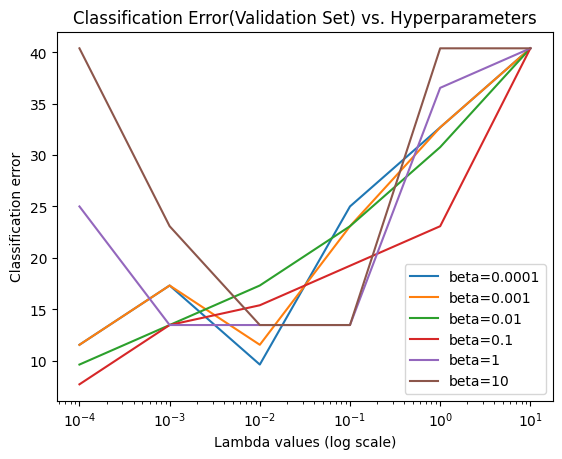

In [414]:
import matplotlib.pyplot as plt

values = [0.0001,0.001, 0.01, 0.1, 1, 10]

for i in range(len(val_ce_data)):
    plt.plot(values, val_ce_data[i], label=f"beta={values[i]}")

plt.xlabel('Lambda values (log scale)')
plt.ylabel('Classification error')
plt.title('Classification Error(Validation Set) vs. Hyperparameters')
plt.legend()
plt.xscale('log')
plt.show()



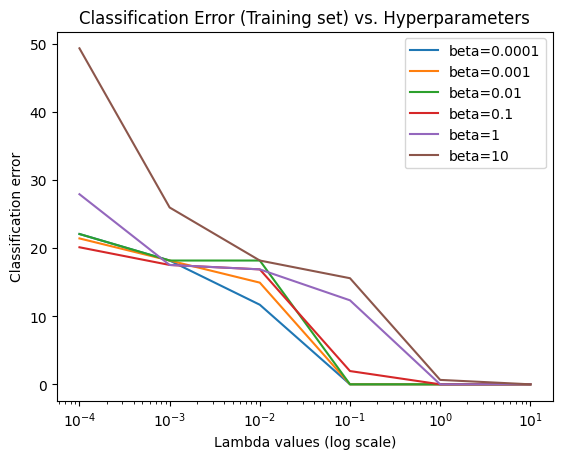

In [415]:
import matplotlib.pyplot as plt

values = [0.0001,0.001, 0.01, 0.1, 1, 10]

for i in range(len(tr_ce_data)):
    plt.plot(values, tr_ce_data[i], label=f"beta={values[i]}")

plt.xlabel('Lambda values (log scale)')
plt.ylabel('Classification error')
plt.title('Classification Error (Training set) vs. Hyperparameters')
plt.legend()
plt.xscale('log')
plt.show()

In [410]:
memory.clear()